# Generate capacity matrices for every cell from Attia, Severson, Whitmer 2021.
Paul Gasper, NREL, February 2020

Simply uses data processing, figure generation code to make a capacity matrix for every cell in the training and test sets.
All code is credited to Peter Attia, unless noted otherwise. See https://github.com/petermattia/revisit-severson-et-al

In [1]:
import copy
from functools import reduce
import glob
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd

## Settings

Set plotting settings:

In [2]:
fig_width = 3.25 # ECS spec is 3.25" width
fig_width_2col = 7
fig_height = (3 / 4) * fig_width # standard ratio

rcParams['figure.autolayout'] = True
rcParams['lines.markersize'] = 5
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

(PG) Set path for saving figures:

In [3]:
figpath = Path.cwd() / 'data' / 'capacity_difference_matrices'

## Load data
The data is stored in the `data` directory. The data was generated by the `generate_voltage_array.m` MATLAB script, which creates three folders of "voltage arrays" for the train, test1, and test2 splits in Severson et al.

We will load each dataset as 3D arrays of `[cell idx, voltage position, cycle number]`.

Note that because cycle 1 is unavailable for one batch, position 0 in axis 2 is cycle 2.
Similarly, cycle 100 is position 98 in axis 2.
In describing the cycle numbers in the text, I assume the first cycle is cycle 1 (i.e. references to cycle number in the text are one-indexed, not zero-indexed).

In [4]:
def sortKeyFunc(s):
    return int(os.path.basename(s)[4:-4])

def load_dataset(folder):
    files = glob.glob(f'./data/{folder}/*.csv')
    files.sort(key=sortKeyFunc) # glob returns list with arbitrary order
    
    l = len(files)
    dataset = np.zeros((l, 1000, 99))
    
    for k, file in enumerate(files):
        cell = np.genfromtxt(file, delimiter=',')
        dataset[k,:,:] = cell # flip voltage dimension
    
    return dataset

Load three datasets (`test1` = primary test set, `test2` = secondary test set):

In [5]:
data_train = load_dataset('train')
data_test1 = load_dataset('test1')
data_test2 = load_dataset('test2')

Load cycle lives:

In [6]:
cycle_lives_train = np.genfromtxt('./data/cycle_lives/train_cycle_lives.csv', delimiter=',')
cycle_lives_test1 = np.genfromtxt('./data/cycle_lives/test1_cycle_lives.csv', delimiter=',')
cycle_lives_test2 = np.genfromtxt('./data/cycle_lives/test2_cycle_lives.csv', delimiter=',')

Confirm 124 cells are loaded:

In [7]:
print(len(data_train) + len(data_test1) + len(data_test2))
print(len(cycle_lives_train) + len(cycle_lives_test1) + len(cycle_lives_test2))

124
124


Define `y` values as log10 of cycle life:

In [8]:
y_train = np.log10(cycle_lives_train)
y_test1 = np.log10(cycle_lives_test1)
y_test2 = np.log10(cycle_lives_test2)

Make a new version of `data_test1`, `cycle_lives_test1` and `y_test1` that exclude the outlier battery:

In [9]:
data_test1_mod = data_test1.copy()
cycle_lives_test1_mod = cycle_lives_test1.copy()
y_test1_mod = y_test1.copy()

data_test1_mod = np.delete(data_test1_mod, 21, axis=0)
cycle_lives_test1_mod = np.delete(cycle_lives_test1_mod, 21)
y_test1_mod = np.delete(y_test1_mod, 21)

## Voltage array illustration

This figure illustrates the voltage array (V vs. Q & cycle number) concept.

In [10]:
# Find sample cell in training set
cellNum = 19
sample = data_train[cellNum,:,:]

# Define Qsub and Qdiv (normalized to cycle 2)
Qsub = (sample[:,:].T - sample[:,0]).T
Qdiv = (sample[:,:].T / sample[:,0]).T

# Set voltage indices for linecuts
idx1 = 220
idx2 = 400

(PG) Plot the capacity matrix for the given sample from the training set:

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


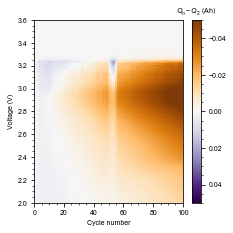

In [11]:
fig, ax = plt.subplots(figsize=(3.25, 3.25),
                       nrows=1, ncols=1)

# Set xlabels
ax.set_xlabel('Cycle number')
ax.set_xlim([0, 100])
    
# Set ylabels
ax.set_ylabel('Voltage (V)')
ax.set_ylim([2, 3.6])

# Plot the capacity difference matrix
im1 = ax.imshow(Qsub, extent=[0, 100, 3.6, 2.0],
                aspect='auto', origin='lower',
                cmap='PuOr', vmin=-0.05, vmax=0.05)
cbar_title = r'$Q_n-Q_2$'+' (Ah)'
cbar = fig.colorbar(im1, ax=ax)
cbar.ax.invert_yaxis()
cbar.ax.set_title(cbar_title, fontsize=7)

plt.tight_layout()

(PG) Make a simple version of the plot with no axes, no colorbar, no labels (get rid of unnecessary information for the deep neural network, I don't want it to need to learn how to read, after all). Create a function, since we'll be making a lot of them. Do this for the capacity difference ($Q_n - Q_2$), the capacity ratio ($Q_n/Q_2$), and the capacity difference ratio ($(Q_n - Q_2)/2$)

In [12]:
# Paul Gasper
def plot_capacity_difference_matrix(data, cell_num, cmap_min=-0.05, cmap_max=0.05, save=0):
    # Calculate the capacity difference matrix
    sample = data[cell_num,:,:]
    Qsub = (sample[:,:].T - sample[:,0]).T
    # Create a plot
    fig, ax = plt.subplots(figsize=(3.25, 3.25),
                           nrows=1, ncols=1)
    # Set axis limits
    ax.set_xlim([0, 100])
    ax.set_ylim([2, 3.6])
    # Plot it
    im1 = ax.imshow(Qsub, extent=[0, 100, 3.6, 2.0],
                    aspect='auto', origin='lower',
                    cmap='PuOr', vmin=cmap_min, vmax=cmap_max)
    plt.axis('off')
    plt.tight_layout()
    if save:
        cellpath = 'cell%d.jpg' % cell_num
        plt.savefig(figpath / cellpath, format='jpg')

In [13]:
# Paul Gasper
def plot_capacity_ratio_matrix(data, cell_num, cmap_min=0.95, cmap_max=1.05, save=0):
    # Calculate the capacity ratio matrix
    sample = data[cell_num,:,:]
    Qsub = (sample[:,:].T / sample[:,0]).T
    # Create a plot
    fig, ax = plt.subplots(figsize=(3.25, 3.25),
                           nrows=1, ncols=1)
    # Set axis limits
    ax.set_xlim([0, 100])
    ax.set_ylim([2, 3.6])
    # Plot it
    im1 = ax.imshow(Qsub, extent=[0, 100, 3.6, 2.0],
                    aspect='auto', origin='lower',
                    cmap='PuOr', vmin=cmap_min, vmax=cmap_max)
    plt.axis('off')
    plt.tight_layout()
    if save:
        cellpath = 'cell%d.jpg' % cell_num
        plt.savefig(figpath / cellpath, format='jpg')

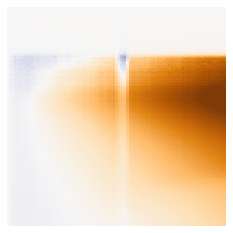

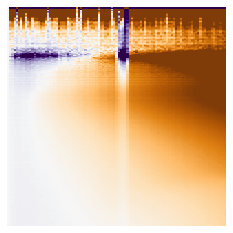

In [14]:
# Paul Gasper
plot_capacity_difference_matrix(data_train, 19)
plot_capacity_ratio_matrix(data_train, 19)

(PG) We'll be making these plots for every single cell in the data set. Since the capacity difference will change between cells, we need to set limits on the colormap that will span the range of capacity differences across the entire data set. Limits of [-0.15, 0.05] seem fine from looking at Figure 6, but we should probably check rigorously, since figure 6 is only one difference, and not over the same range we are concerned with ($Q_{100} - Q_{10}$ versus $Q_n - Q_2$).

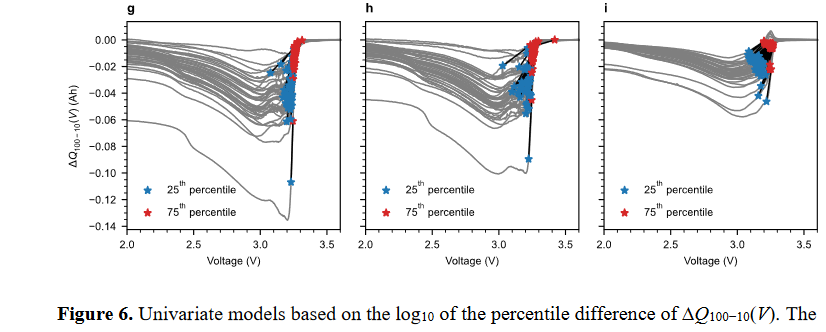

In [15]:
# Paul Gasper
data = np.concatenate((data_train, data_test1, data_test2))
np.shape(data) # cells x voltage x cycle

(124, 1000, 99)

In [16]:
# Paul Gasper
Qdiff_mins, Qdiff_maxs = np.zeros((124)), np.zeros((124))
idx = 0
for cell_data in zip(data[iCell,:,:] for iCell in np.arange(np.shape(data)[0])):
    cell_data = cell_data[0] # get the ndarray out of the zipped tuple
    Qdiff = (cell_data[:,:].T - cell_data[:,0]).T
    Qdiff_mins[idx] = np.min(Qdiff.flat)
    Qdiff_maxs[idx] = np.max(Qdiff.flat)
    idx += 1
    ## Code to check for outliers / problems in calculating the min/max. There's some funky stuff in there
    #print(np.min(Qdiff.flat))
    #print(np.max(Qdiff.flat))
    #print()

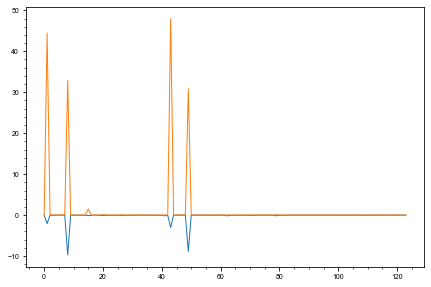

In [17]:
# Paul Gasper
plt.plot(Qdiff_mins)
plt.plot(Qdiff_maxs)

(PG) There's some outlier mins and outlier maxes. Investigate closer to see where reasonable limits are, we want to exclude these outliers (they will just be the max/min color of our colorbar. Several percentiles were searched to find 'fair' ones. From Figure 6 before, we know one cell in the training set has a $Q_{100} - Q_{10} = -0.14$, so we know the 'fair' min has to be at least that small. 'Unfair' mins are due to the temperature change in the chamber, which causes a vertical slice of the capacity difference matrix to be much more negative than the rest of the capacity difference matrix (see between cycles 50 and 55 in the plotted capacity difference matrix for training cell 19). There's also a number of 'unfair' maxes, which might be due to the same thing.

(-0.1332303188, 0.07946559999999996, 0.1332303188)

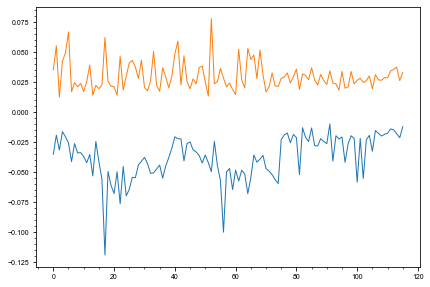

In [18]:
# Paul Gasper
lower_lim = np.percentile(Qdiff_mins, 6)
upper_lim = np.percentile(Qdiff_maxs, 94)
plt.plot(Qdiff_mins[Qdiff_mins >= lower_lim])
plt.plot(Qdiff_maxs[Qdiff_maxs <= upper_lim])
lim = np.max(np.abs((lower_lim, upper_lim)))
lower_lim, upper_lim, lim

C:\Users\pgasper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


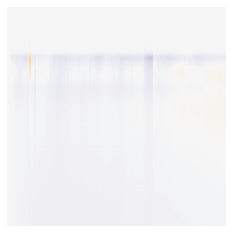

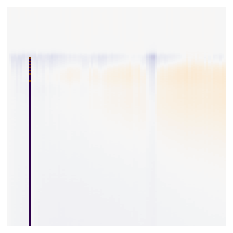

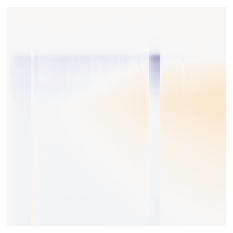

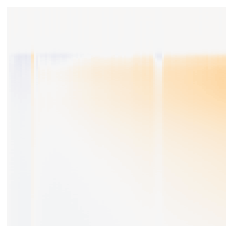

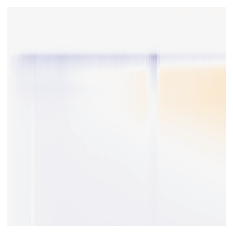

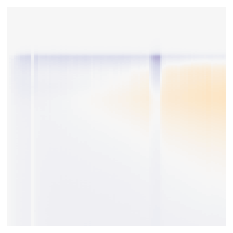

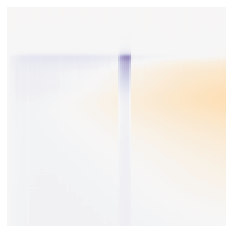

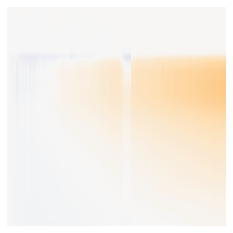

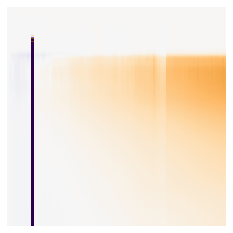

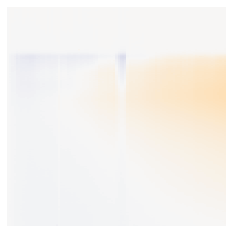

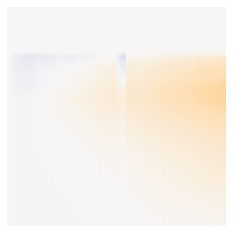

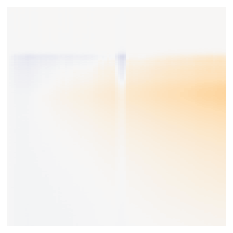

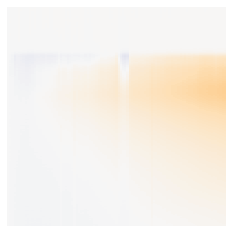

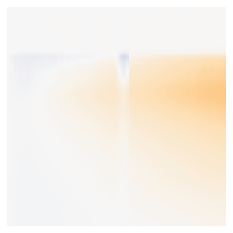

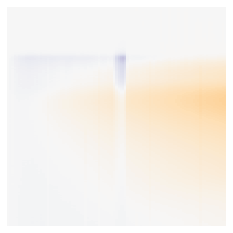

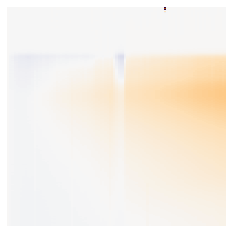

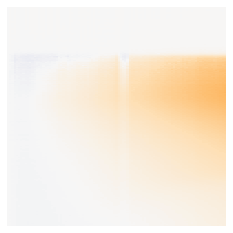

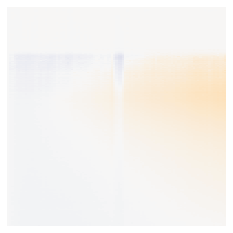

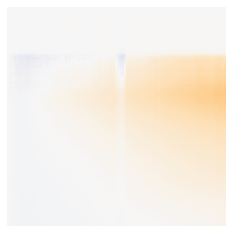

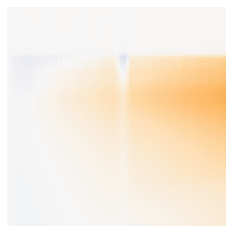

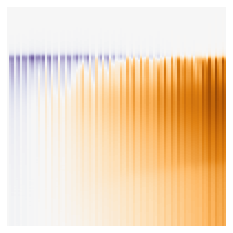

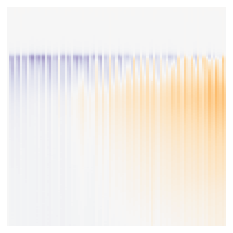

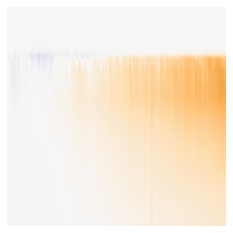

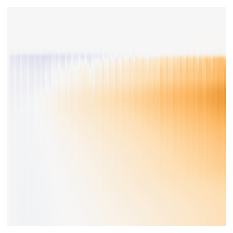

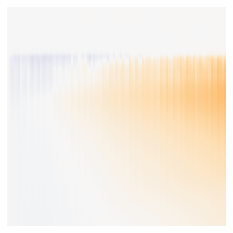

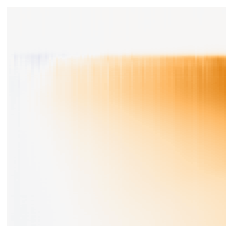

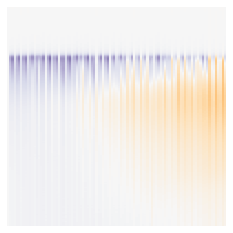

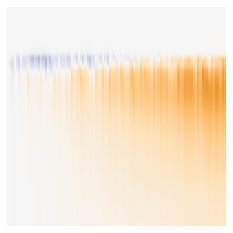

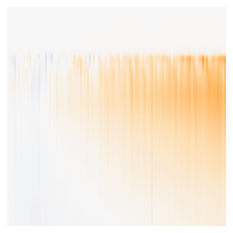

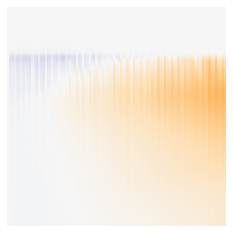

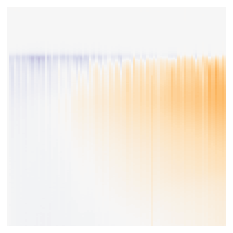

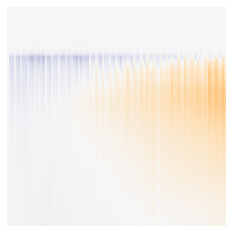

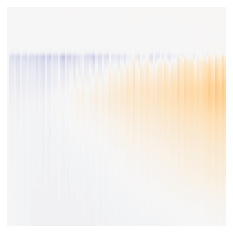

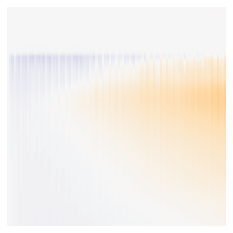

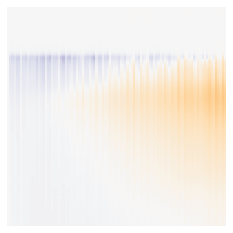

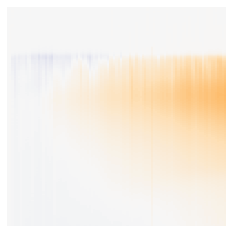

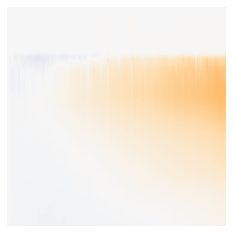

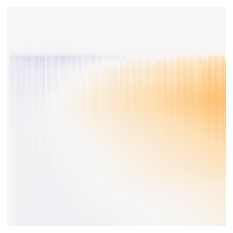

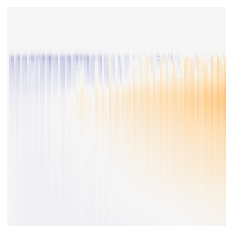

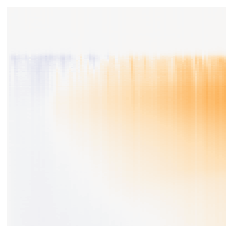

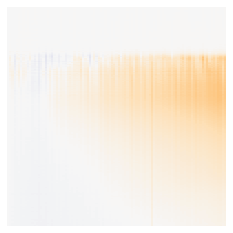

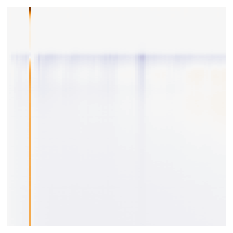

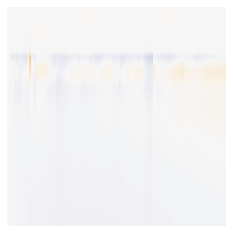

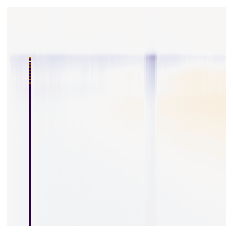

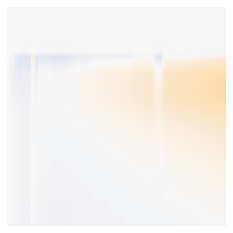

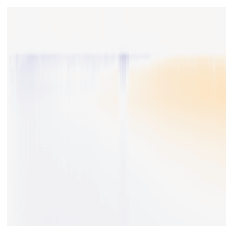

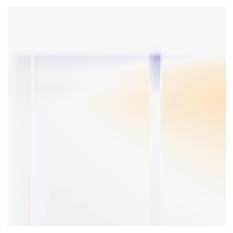

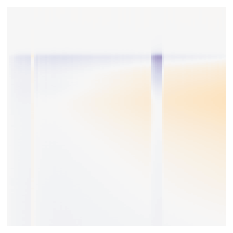

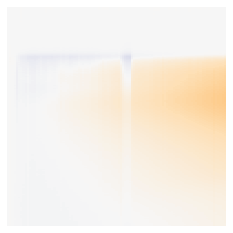

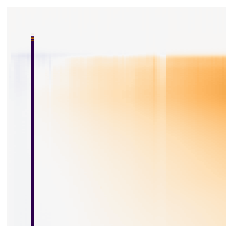

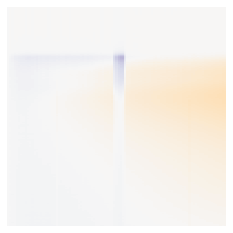

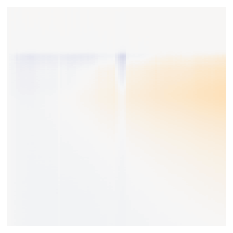

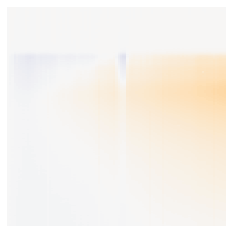

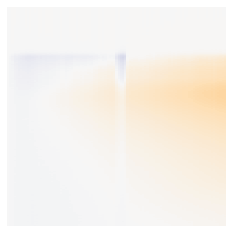

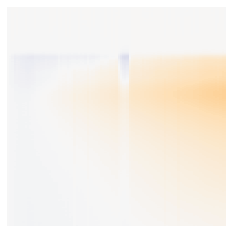

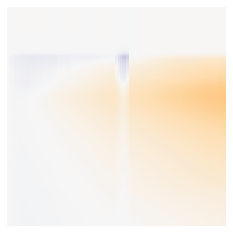

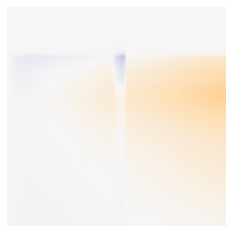

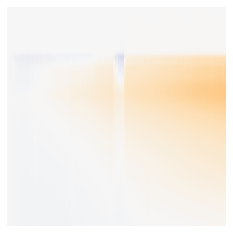

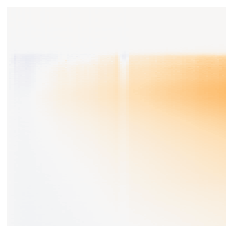

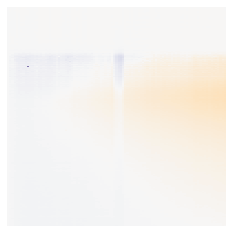

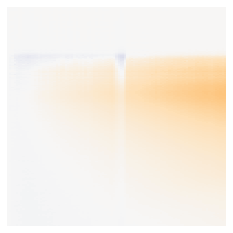

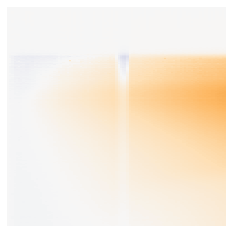

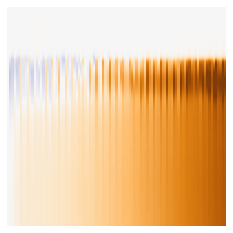

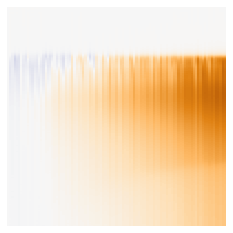

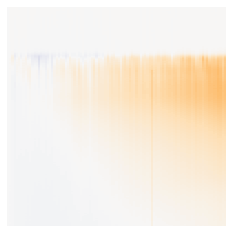

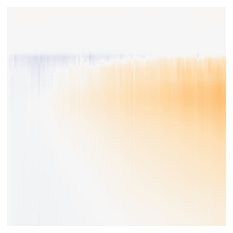

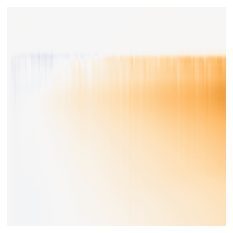

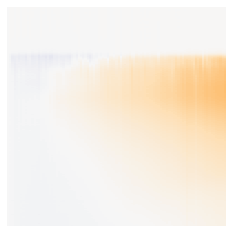

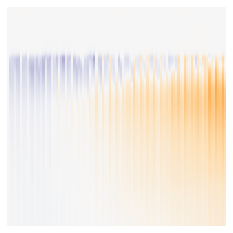

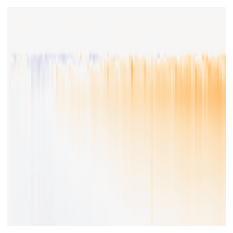

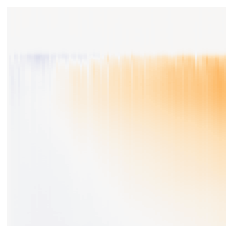

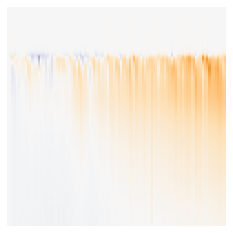

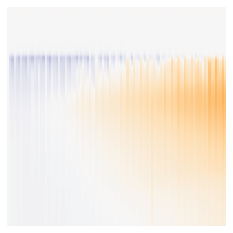

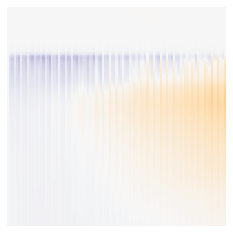

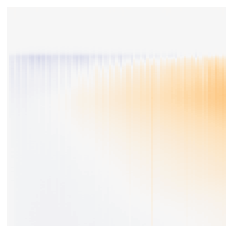

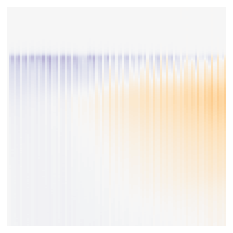

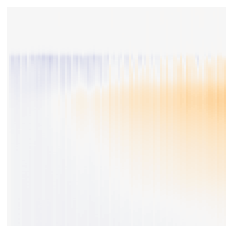

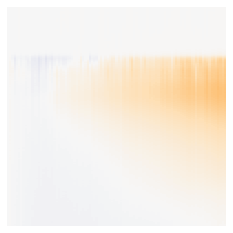

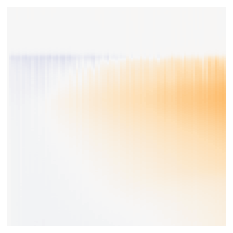

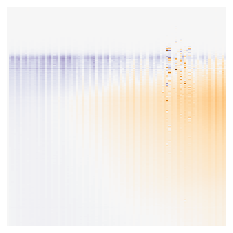

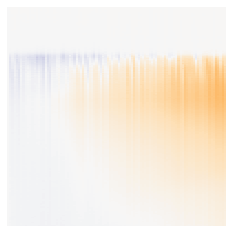

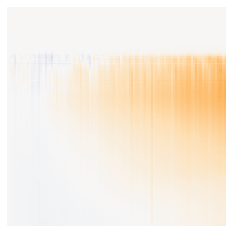

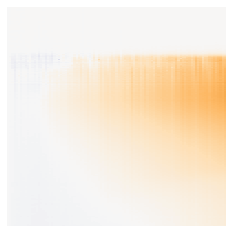

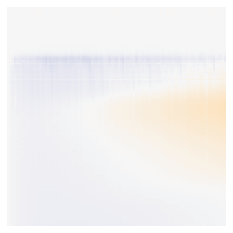

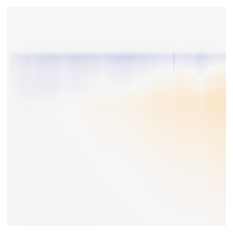

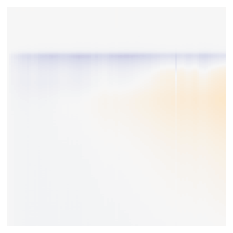

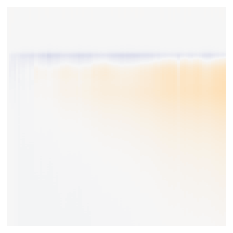

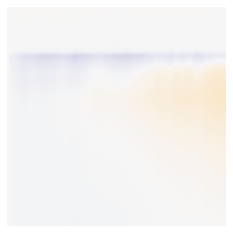

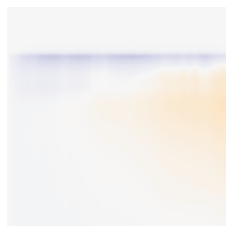

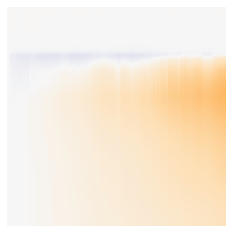

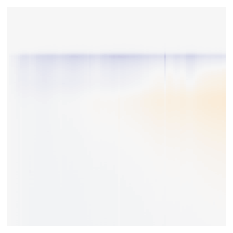

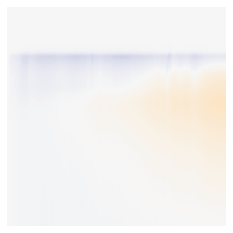

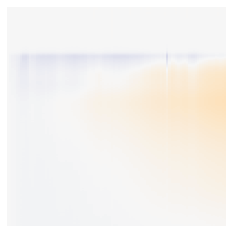

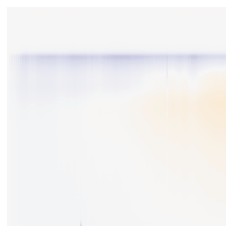

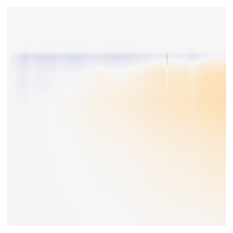

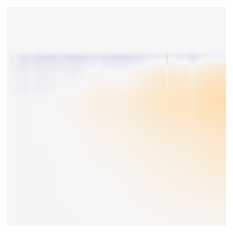

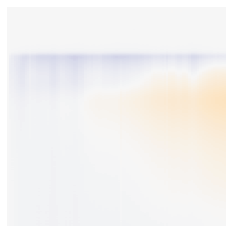

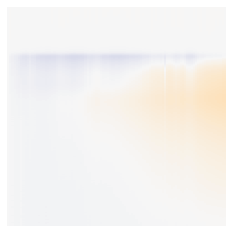

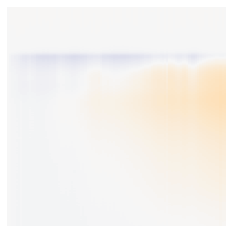

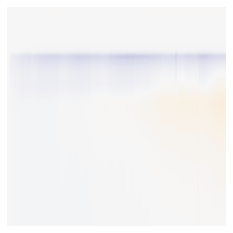

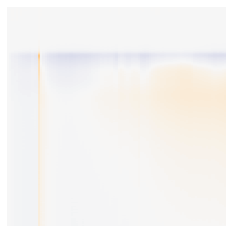

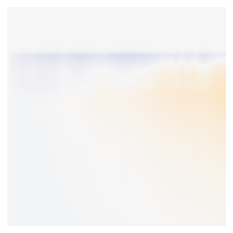

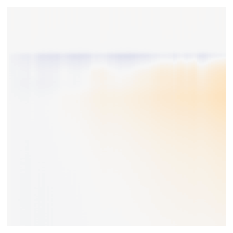

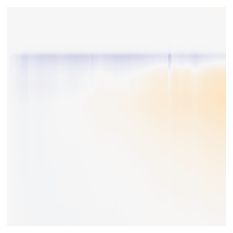

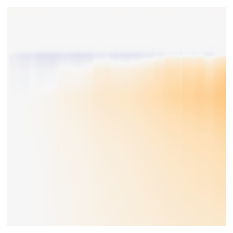

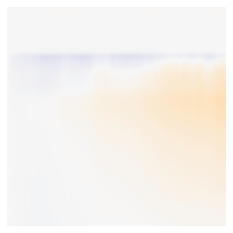

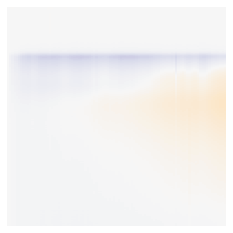

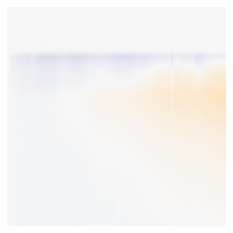

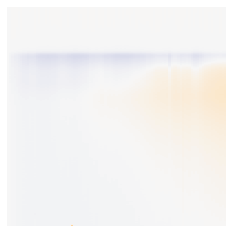

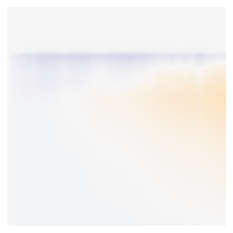

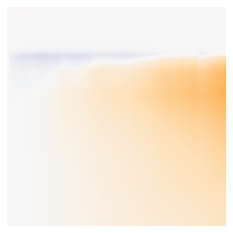

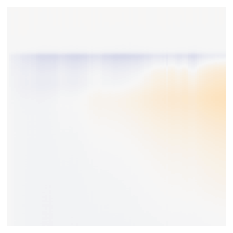

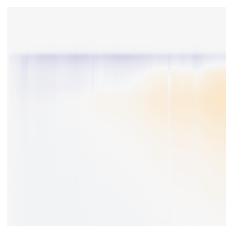

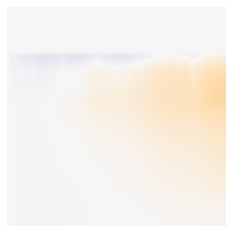

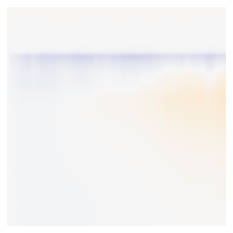

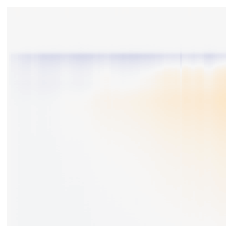

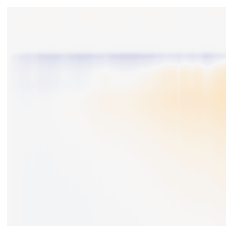

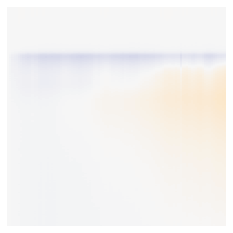

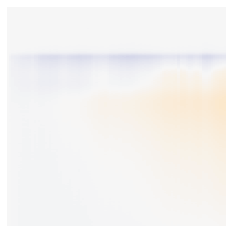

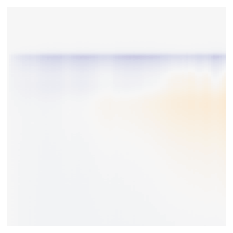

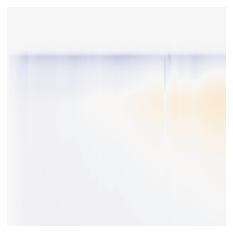

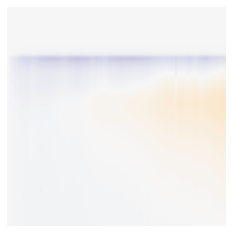

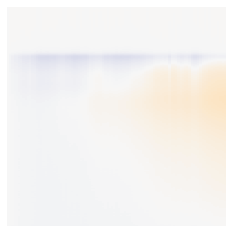

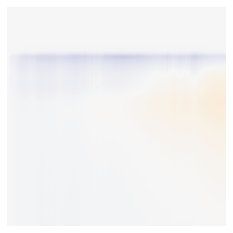

In [19]:
# Paul Gasper
oldpath = Path.cwd() / 'data' / 'capacity_difference_matrices'
figpath = oldpath / 'train'
for i in np.arange(np.shape(data_train)[0]):
    plot_capacity_difference_matrix(data_train, i, -lim, lim, 1)
figpath = oldpath / 'test1'
for i in np.arange(np.shape(data_test1)[0]):
    plot_capacity_difference_matrix(data_test1, i, -lim, lim, 1)
figpath = oldpath / 'test2'
for i in np.arange(np.shape(data_test2)[0]):
    plot_capacity_difference_matrix(data_test2, i, -lim, lim, 1)

(PG) Do the same thing as above, but with the non-dimensional capacity ratio instead of the capacity difference.

In [20]:
# Paul Gasper
Qratio_mins, Qratio_maxs = np.zeros((124)), np.zeros((124))
idx = 0
for cell_data in zip(data[iCell,:,:] for iCell in np.arange(np.shape(data)[0])):
    cell_data = cell_data[0] # get the ndarray out of the zipped tuple
    Qratio = (cell_data[:,:].T / cell_data[:,0]).T
    Qratio_mins[idx] = np.min(Qratio.flat)
    Qratio_maxs[idx] = np.max(Qratio.flat)
    idx += 1
    ## Code to check for outliers / problems in calculating the min/max. There's some funky stuff in there
    #print(np.min(Qdiff.flat))
    #print(np.max(Qdiff.flat))
    #print()

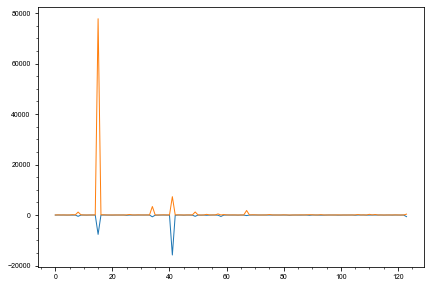

In [21]:
# Paul Gasper
plt.plot(Qratio_mins)
plt.plot(Qratio_maxs)

(-188.95156996021223, 320.9149442552378, 320.9149442552378)

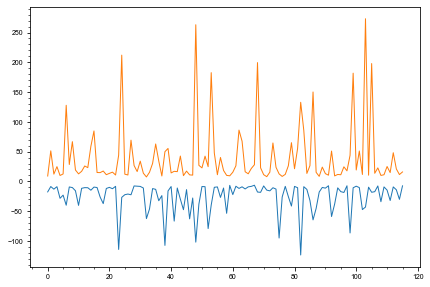

In [22]:
# Paul Gasper
lower_lim = np.percentile(Qratio_mins, 6)
upper_lim = np.percentile(Qratio_maxs, 94)
plt.plot(Qratio_mins[Qratio_mins >= lower_lim])
plt.plot(Qratio_maxs[Qratio_maxs <= upper_lim])
lim = np.max(np.abs((lower_lim, upper_lim)))
lower_lim, upper_lim, lim

(PG) These limits may need to be set more manually. The ratios are a mess! Too sensitive to noise or something.

C:\Users\pgasper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


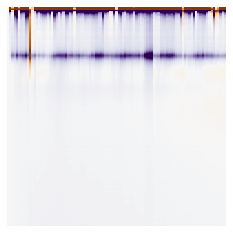

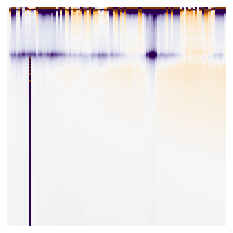

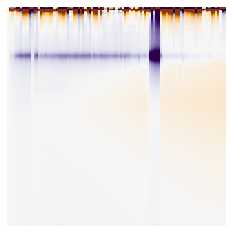

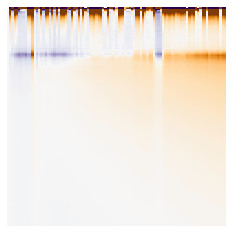

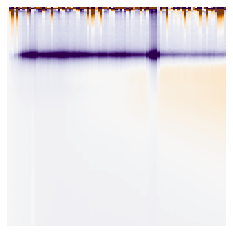

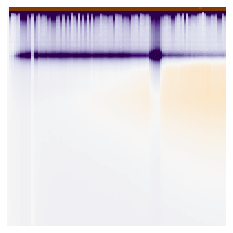

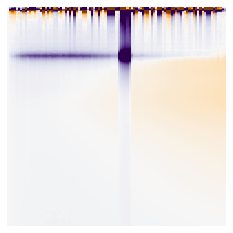

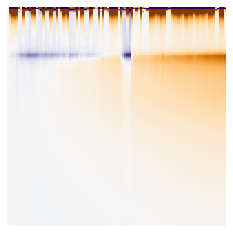

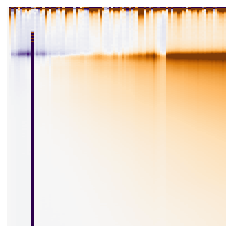

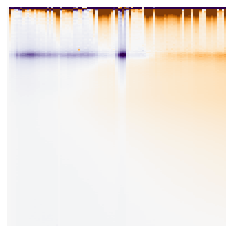

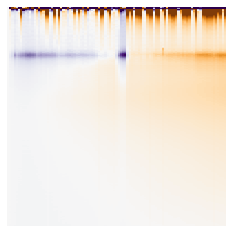

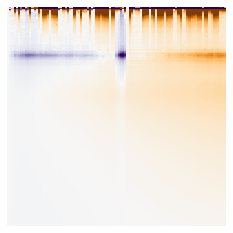

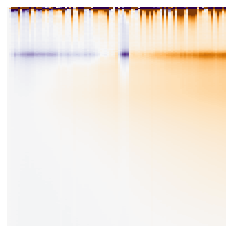

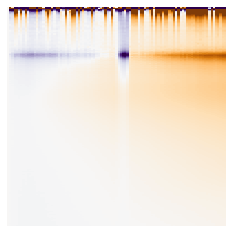

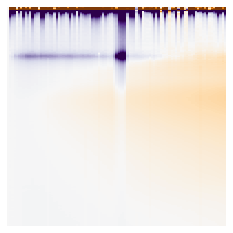

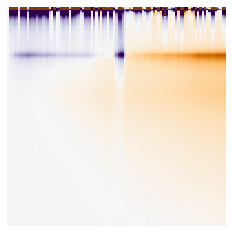

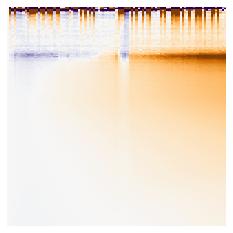

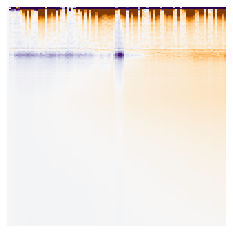

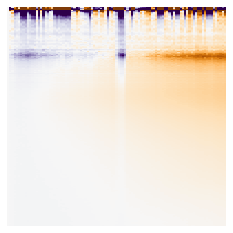

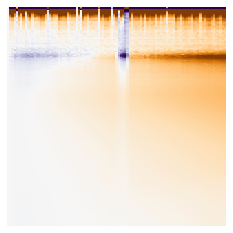

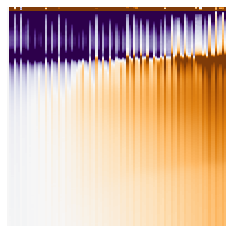

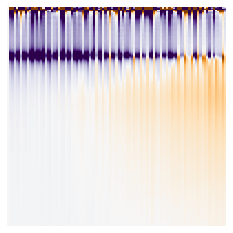

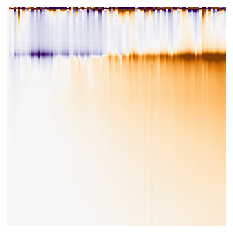

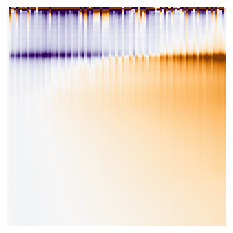

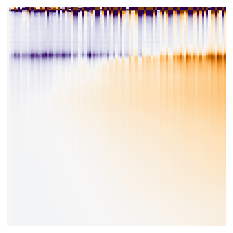

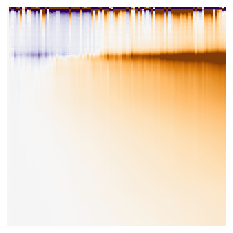

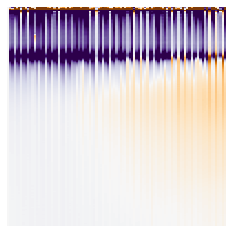

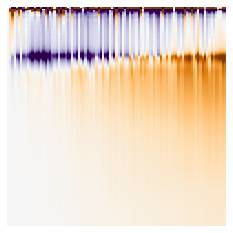

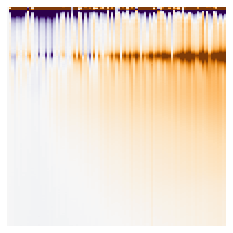

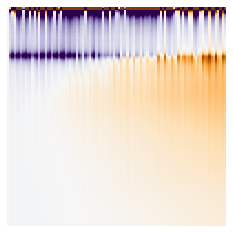

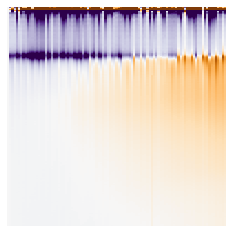

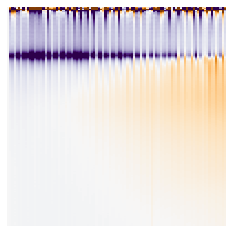

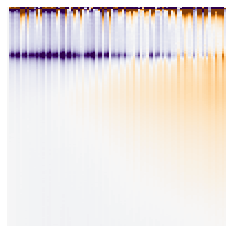

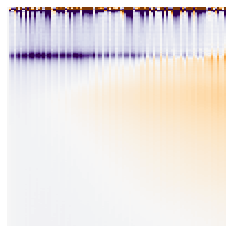

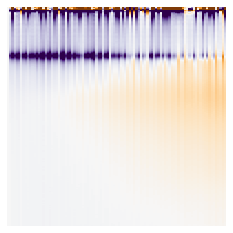

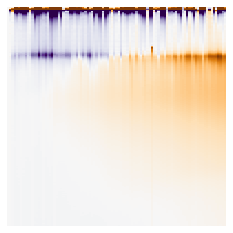

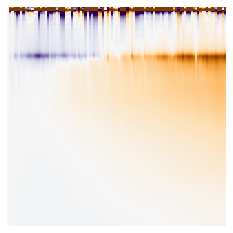

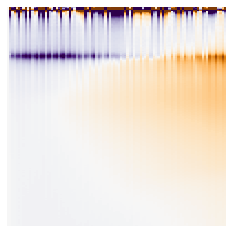

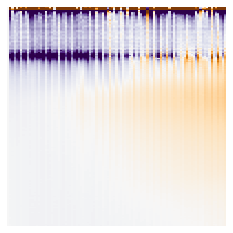

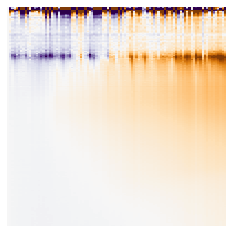

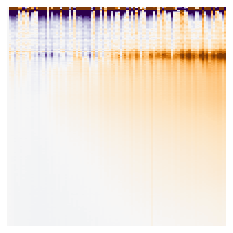

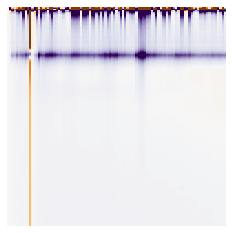

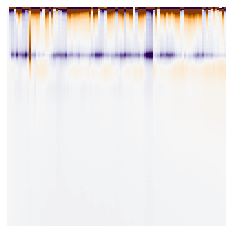

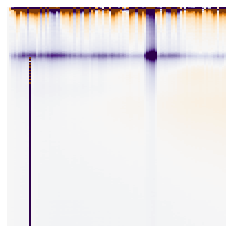

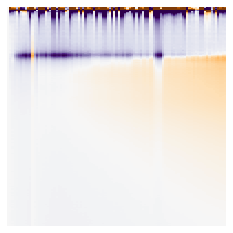

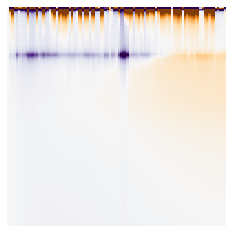

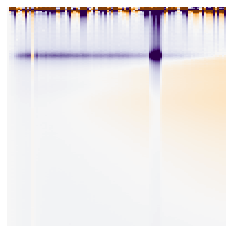

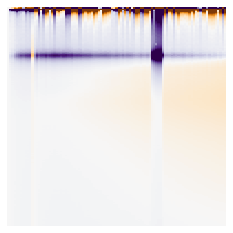

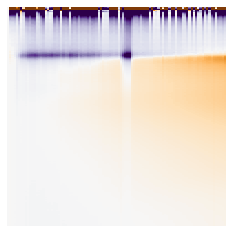

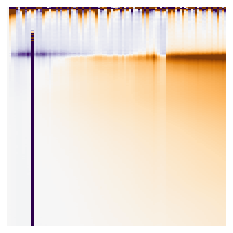

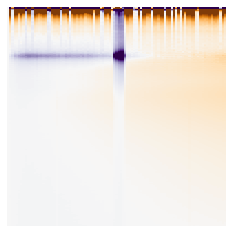

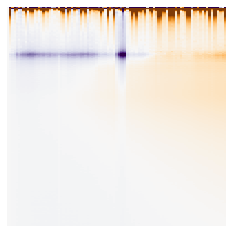

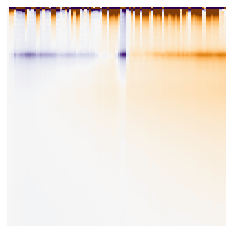

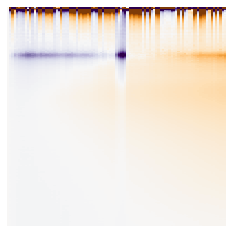

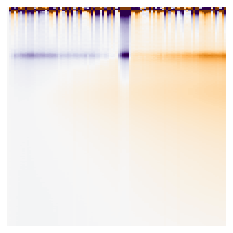

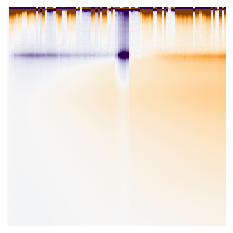

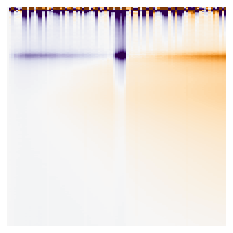

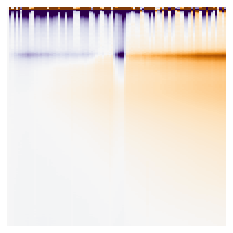

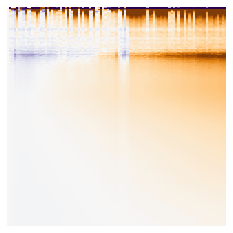

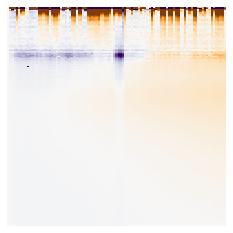

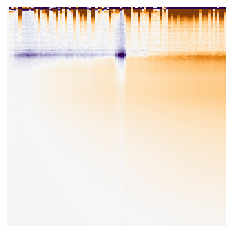

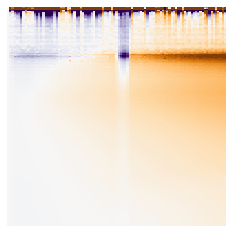

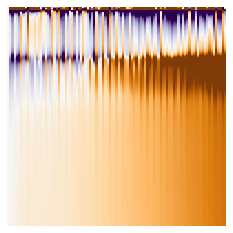

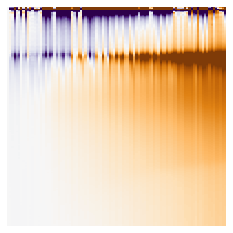

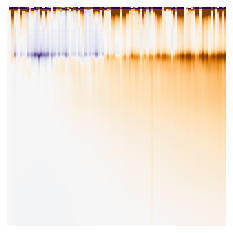

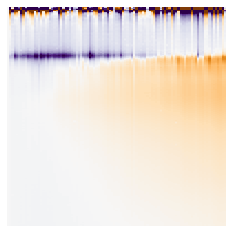

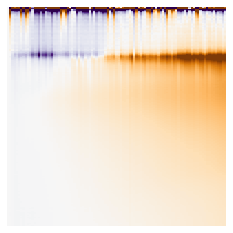

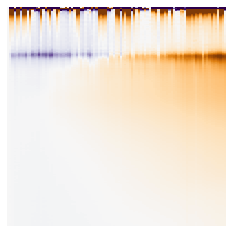

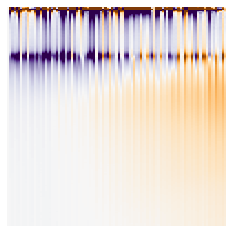

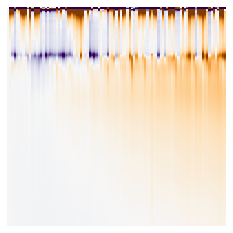

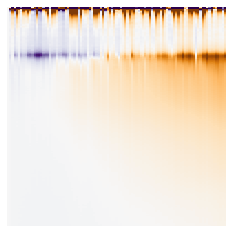

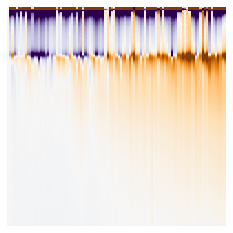

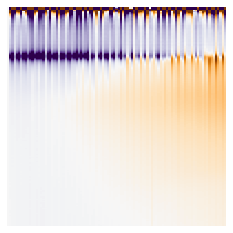

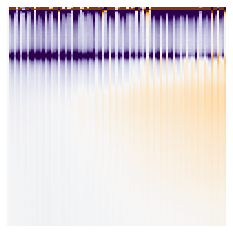

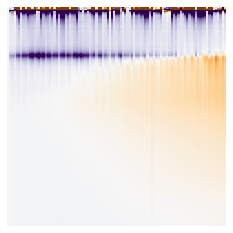

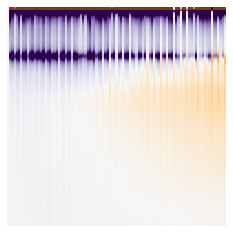

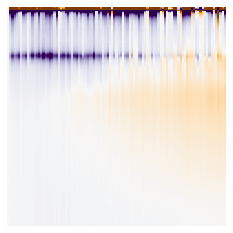

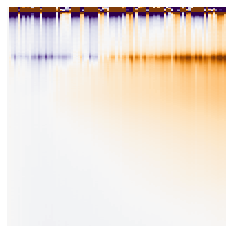

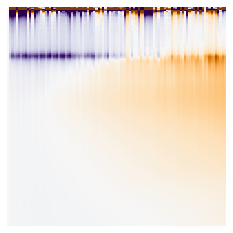

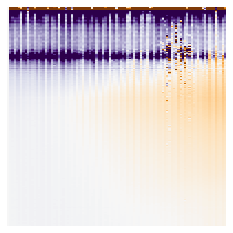

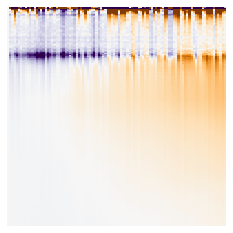

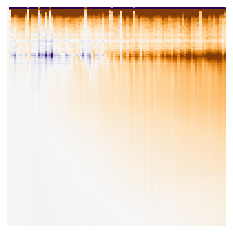

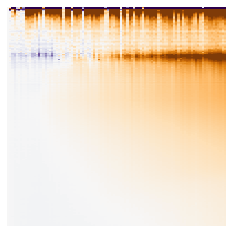

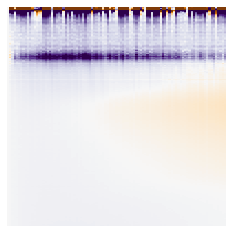

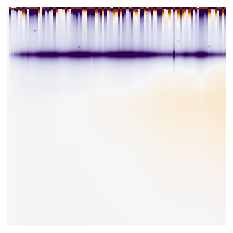

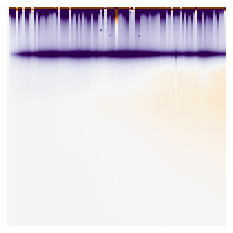

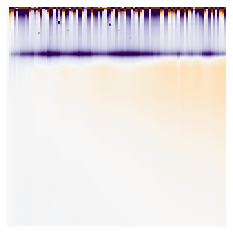

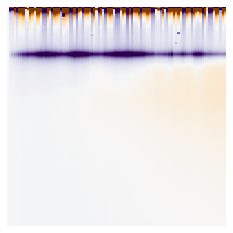

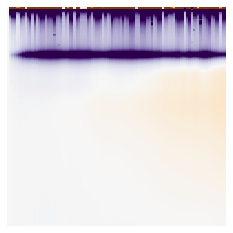

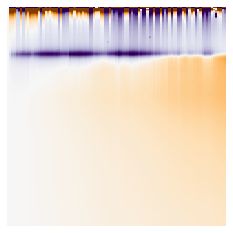

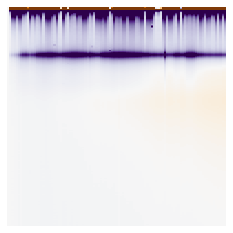

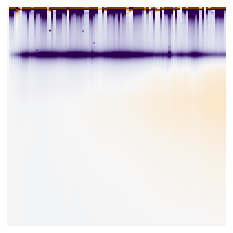

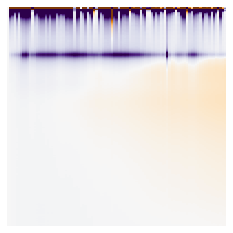

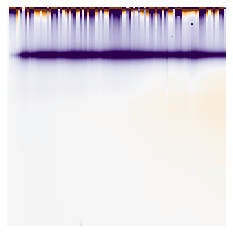

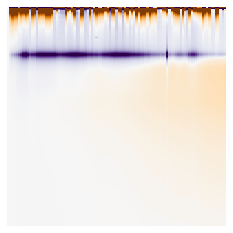

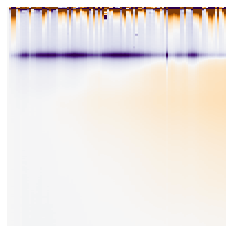

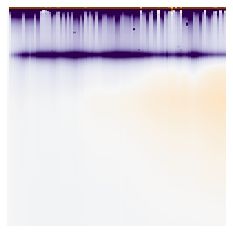

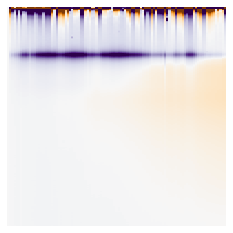

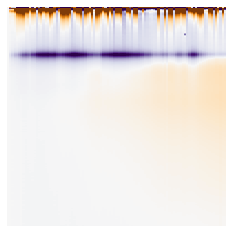

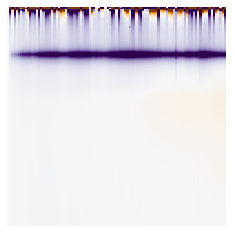

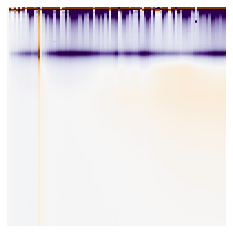

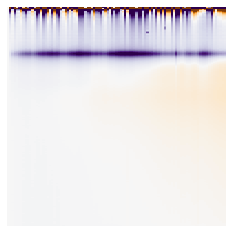

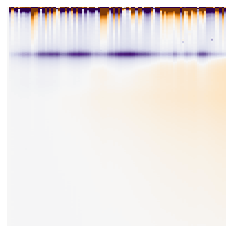

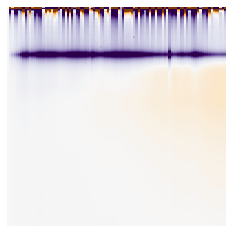

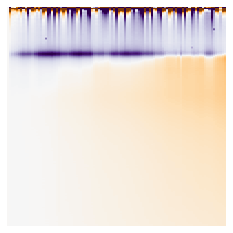

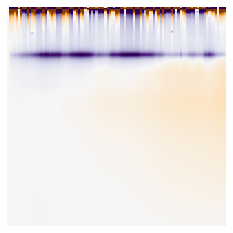

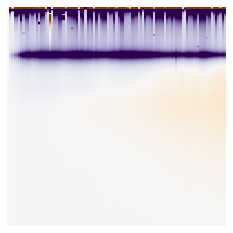

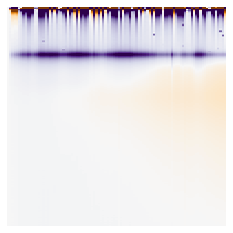

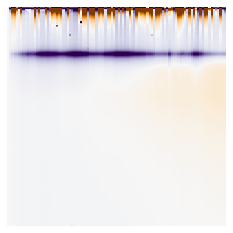

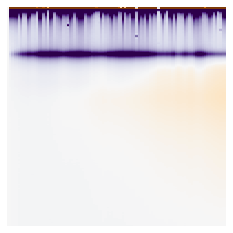

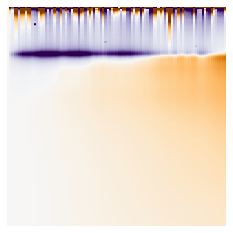

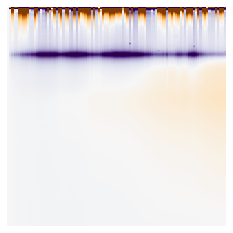

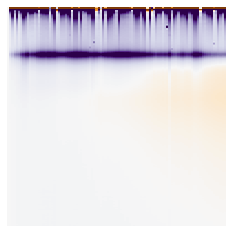

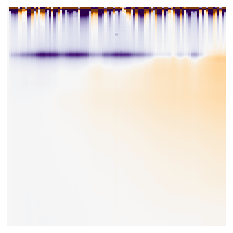

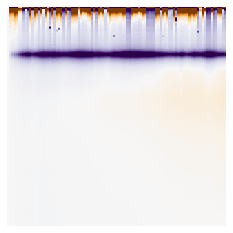

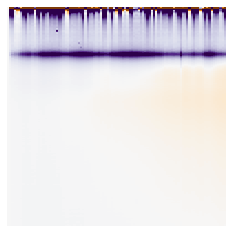

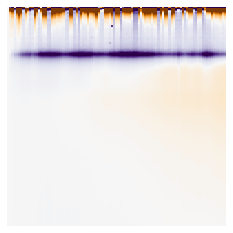

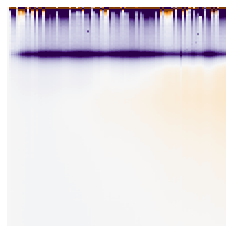

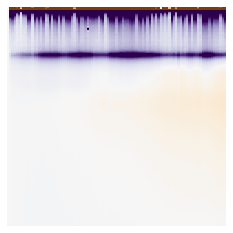

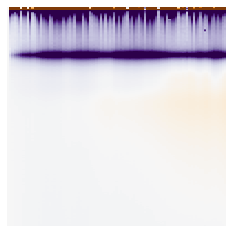

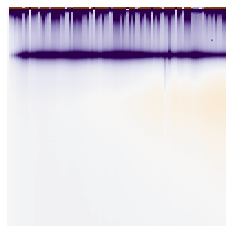

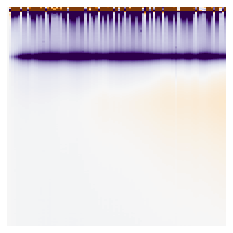

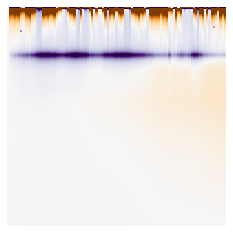

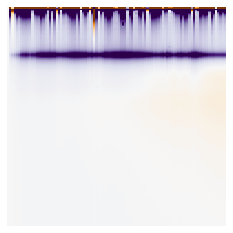

In [23]:
# Paul Gasper
lim = 0.15
oldpath = Path.cwd() / 'data' / 'capacity_ratio_matrices'
figpath = oldpath / 'train'
for i in np.arange(np.shape(data_train)[0]):
    plot_capacity_ratio_matrix(data_train, i, 1-lim, 1+lim, 1)
figpath = oldpath / 'test1'
for i in np.arange(np.shape(data_test1)[0]):
    plot_capacity_ratio_matrix(data_test1, i, 1-lim, 1+lim, 1)
figpath = oldpath / 'test2'
for i in np.arange(np.shape(data_test2)[0]):
    plot_capacity_ratio_matrix(data_test2, i, 1-lim, 1+lim, 1)